In [1]:
%load_ext autoreload
%autoreload 2

### Triplet Loss

We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<img src="./images/triplet.png" height="422" width="722" >

Triplet loss is given by the following :-

$$ \mathcal{L}(I_{1}, I_{2}, I_{3}) = ReLU\{m + (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{2}})^{2} - (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{3}})^{2} \}$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import TripletCD

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    
    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)

    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [7]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 1.000077
Train: [12800/50000 (26%)]	Loss: 1.003512
Train: [25600/50000 (51%)]	Loss: 0.994936
Train: [38400/50000 (77%)]	Loss: 0.690928
Epoch: 1/20. Train set: Average loss: 0.7994
Epoch: 1/20. Validation set: Average loss: 0.4596
Train: [0/50000 (0%)]	Loss: 0.341802
Train: [12800/50000 (26%)]	Loss: 0.374067
Train: [25600/50000 (51%)]	Loss: 0.310781
Train: [38400/50000 (77%)]	Loss: 0.292790
Epoch: 2/20. Train set: Average loss: 0.3118
Epoch: 2/20. Validation set: Average loss: 0.2897
Train: [0/50000 (0%)]	Loss: 0.281681
Train: [12800/50000 (26%)]	Loss: 0.247551
Train: [25600/50000 (51%)]	Loss: 0.238002
Train: [38400/50000 (77%)]	Loss: 0.220439
Epoch: 3/20. Train set: Average loss: 0.2299
Epoch: 3/20. Validation set: Average loss: 0.2422
Train: [0/50000 (0%)]	Loss: 0.117155
Train: [12800/50000 (26%)]	Loss: 0.199547
Train: [25600/50000 (51%)]	Loss: 0.178816
Train: [38400/50000 (77%)]	Loss: 0.170261
Epoch: 4/20. Train set: Average loss: 0.1807
Epoch: 4/20. Valid

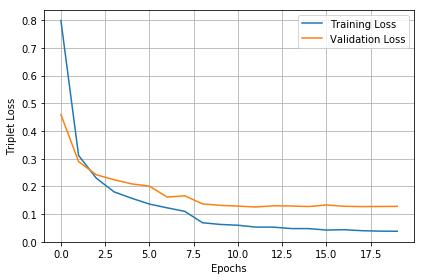

In [8]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

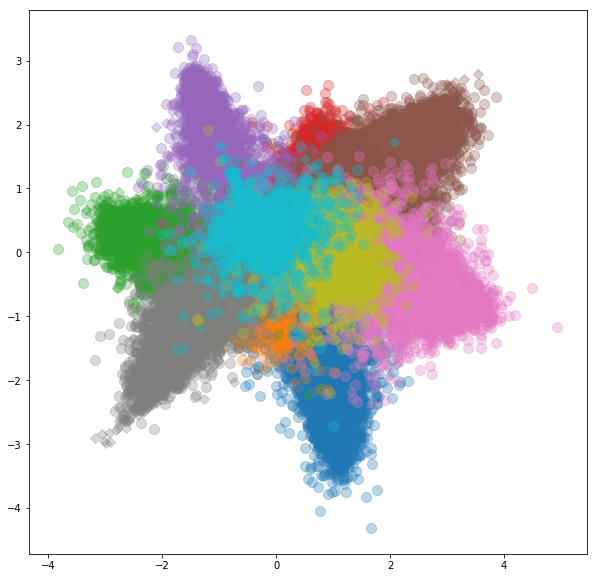

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

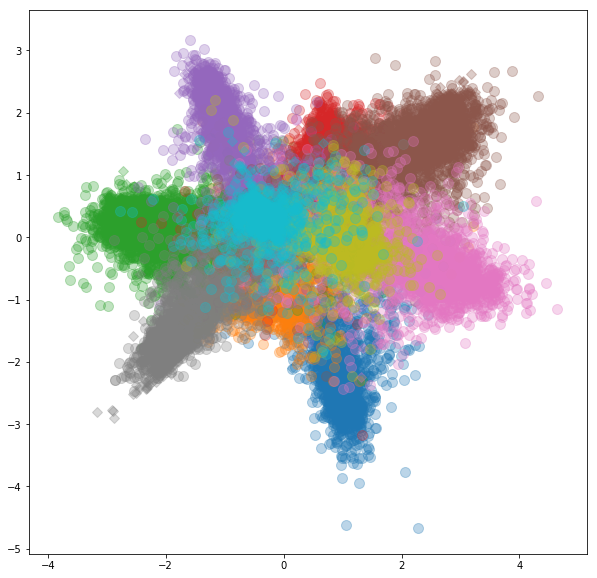

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [6]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)


triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 1.000079
Train: [12800/50000 (26%)]	Loss: 0.434978
Train: [25600/50000 (51%)]	Loss: 0.214394
Train: [38400/50000 (77%)]	Loss: 0.154708
Epoch: 1/20. Train set: Average loss: 0.2394
Epoch: 1/20. Validation set: Average loss: 0.1579
Train: [0/50000 (0%)]	Loss: 0.090735
Train: [12800/50000 (26%)]	Loss: 0.111503
Train: [25600/50000 (51%)]	Loss: 0.105770
Train: [38400/50000 (77%)]	Loss: 0.083491
Epoch: 2/20. Train set: Average loss: 0.0915
Epoch: 2/20. Validation set: Average loss: 0.0774
Train: [0/50000 (0%)]	Loss: 0.042153
Train: [12800/50000 (26%)]	Loss: 0.055405
Train: [25600/50000 (51%)]	Loss: 0.052129
Train: [38400/50000 (77%)]	Loss: 0.045599
Epoch: 3/20. Train set: Average loss: 0.0506
Epoch: 3/20. Validation set: Average loss: 0.0751
Train: [0/50000 (0%)]	Loss: 0.071078
Train: [12800/50000 (26%)]	Loss: 0.040888
Train: [25600/50000 (51%)]	Loss: 0.040819
Train: [38400/50000 (77%)]	Loss: 0.043573
Epoch: 4/20. Train set: Average loss: 0.0396
Epoch: 4/20. Valid

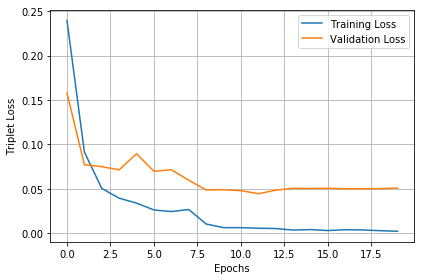

In [8]:
lossDict=fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

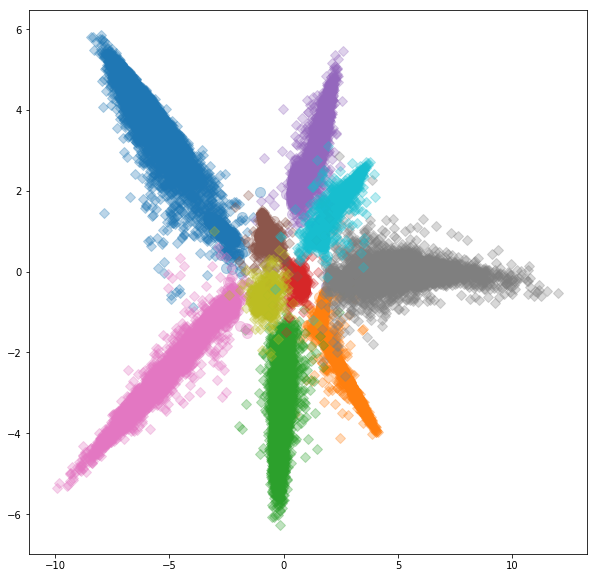

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

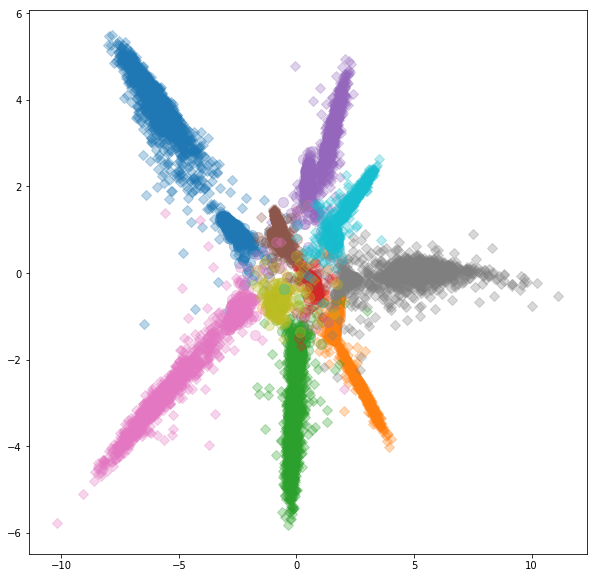

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

In [13]:
model = TripletNet(embedding_net_primary, embedding_net_helper)
torch.save(model.state_dict(), './x.pt')

In [14]:
model1 = TripletNet(embedding_net_primary, embedding_net_helper)
model.load_state_dict(torch.load('./x.pt'))

In [15]:
model1

TripletNet (
  (embedding_net_1): EmbeddingNet (
    (convnet): Sequential (
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU (1)
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU (1)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (1600 -> 256)
      (1): PReLU (1)
      (2): Linear (256 -> 256)
      (3): PReLU (1)
      (4): Linear (256 -> 2)
    )
  )
  (embedding_net_2): EmbeddingNet (
    (convnet): Sequential (
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU (1)
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU (1)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (1600 -> 256)
      (1): PReLU (1)
      (2):